In [172]:
# load a matrix from a space-separated file and show it as an image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch



In [173]:
def load_adaptation_trace(file_path): 
        df = pd.read_csv(file_path)
        arr = df.Adaptation.to_numpy()
        return arr

In [174]:
LOSS_IS_PER_SAMPLE = False
result_root = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/'
coin_bics_path = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/coin_bics.txt'
paradigm_ = {k: 'evoked' if k <= 8 else 'spontaneous' for k in range(1,17)}
coin_bics = np.loadtxt(coin_bics_path)
# exp_datasets = [ load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv') for i in range(1,17)]
exp_datasets = []
loss_traces= {}
output_traces= {}
for i in range(1,17): 
    exp_datasets.append(load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv'))
    for j in range(1,6):
        result_dir = f'realthing403ctrl_seeds/run{i}_seed{j}' 
        try: 
            loss_traces[(i,j)] = np.genfromtxt(f'{result_root}/{result_dir}/loss.csv', delimiter=',')
            output_traces[(i,j)] = np.loadtxt(f'{result_root}/{result_dir}/pred_a.txt')
        except:
            loss_traces[(i,j)] = None
            output_traces[(i,j)] = None

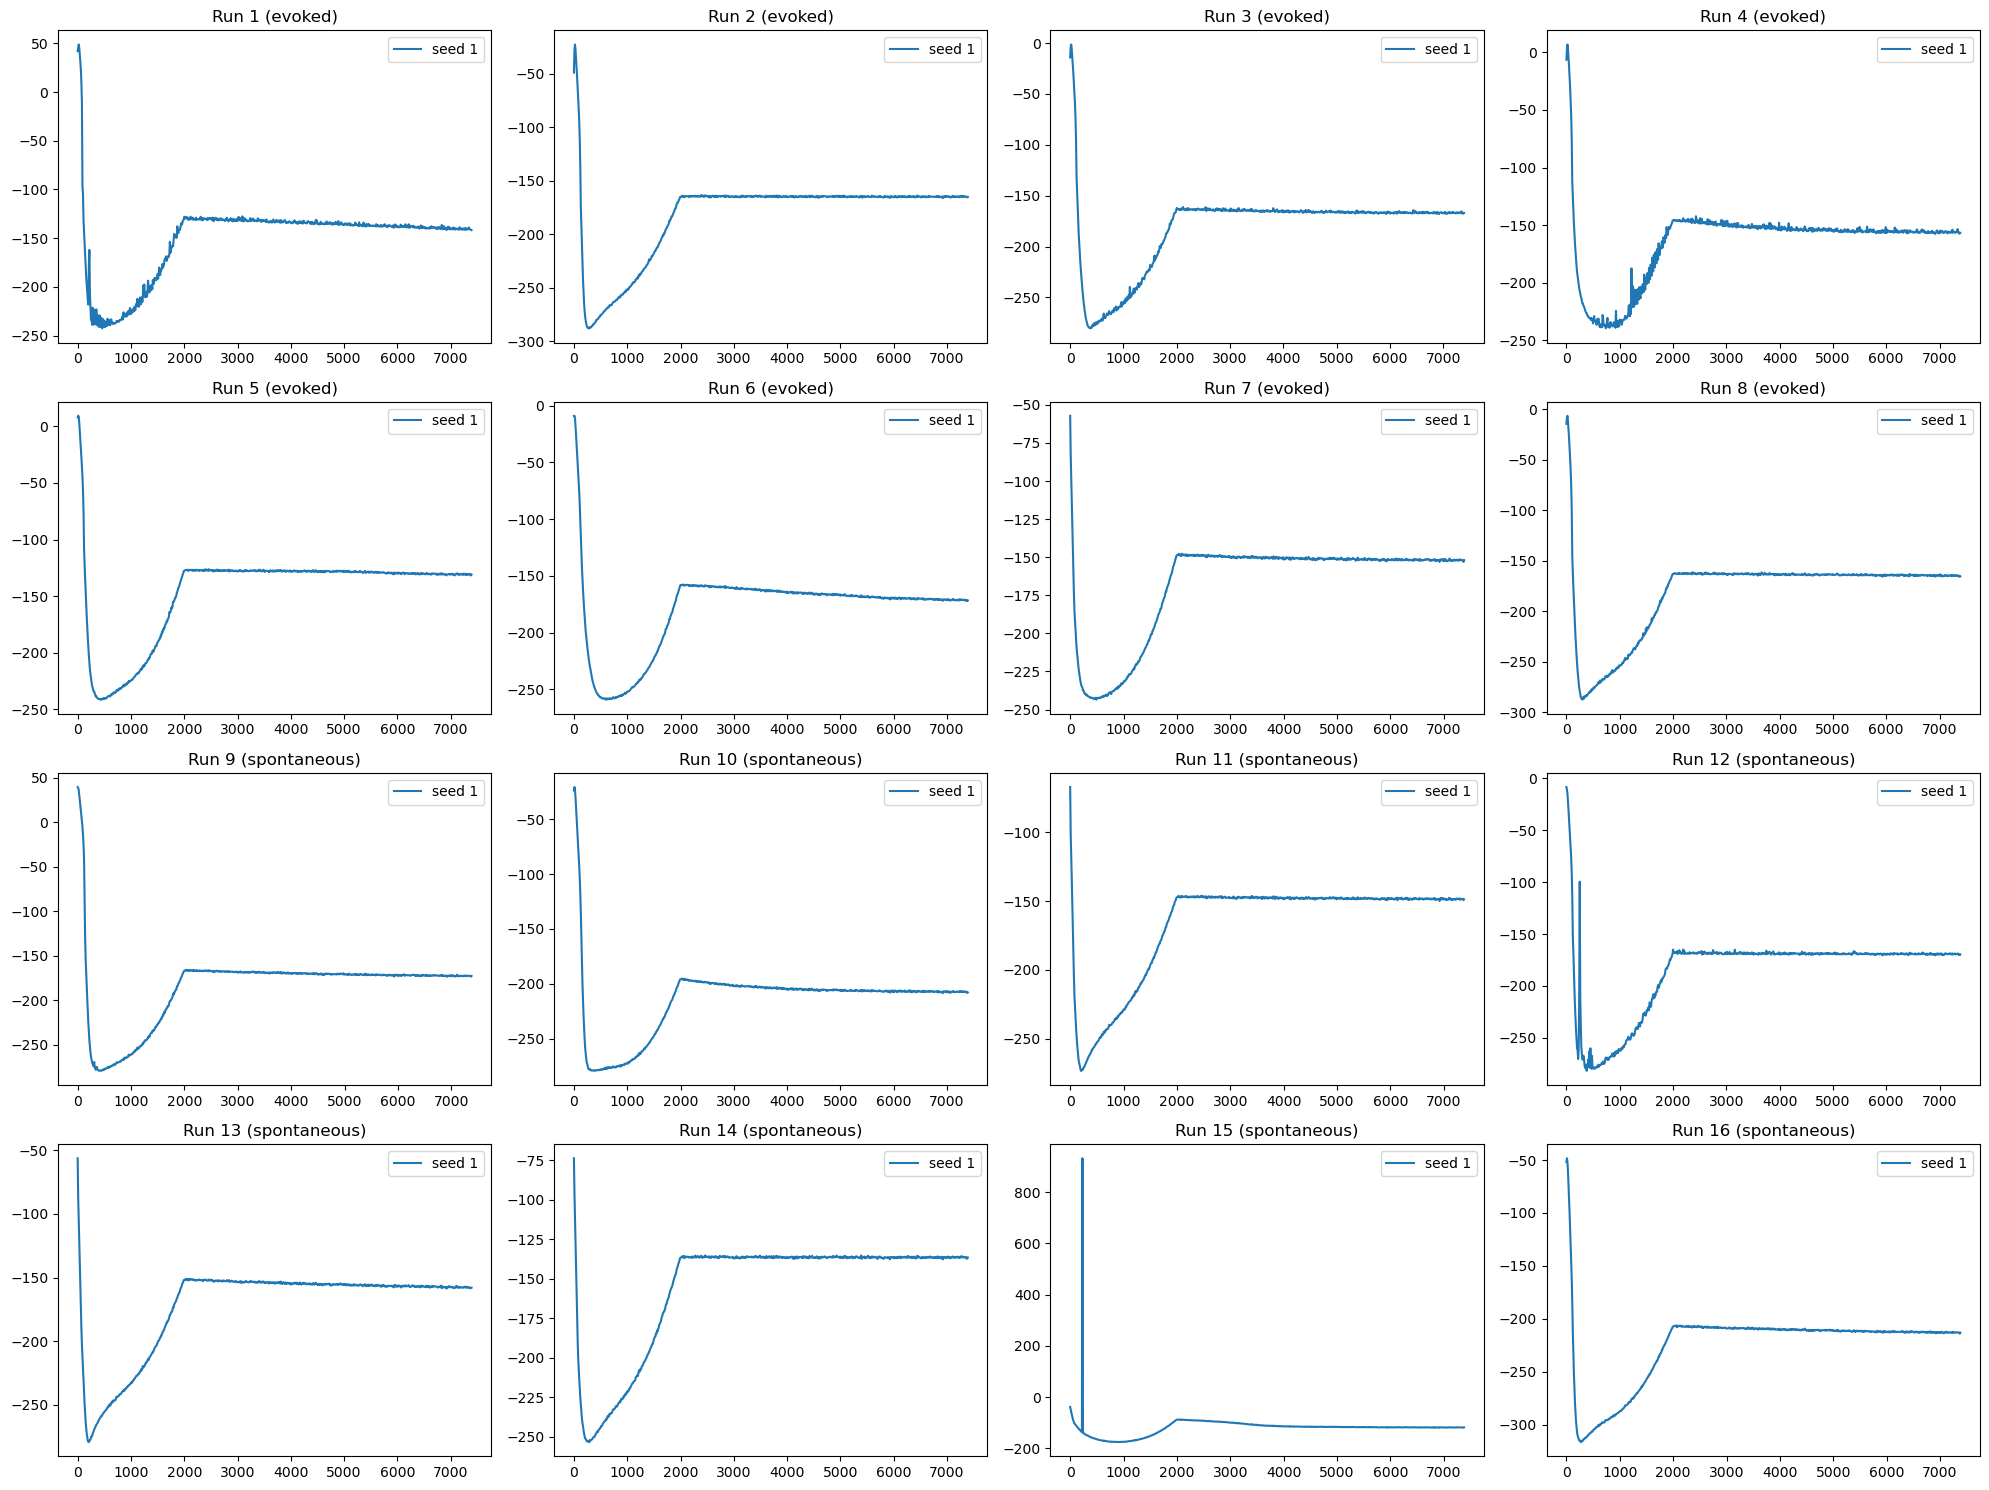

In [175]:
#plot all the loss traces. subplot per run and line per seed
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    for j in range(1,6):
        if loss_traces[(i,j)] is not None:
            ax.plot(loss_traces[(i,j)][:,0],loss_traces[(i,j)][:,-1], label=f'seed {j}')
    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

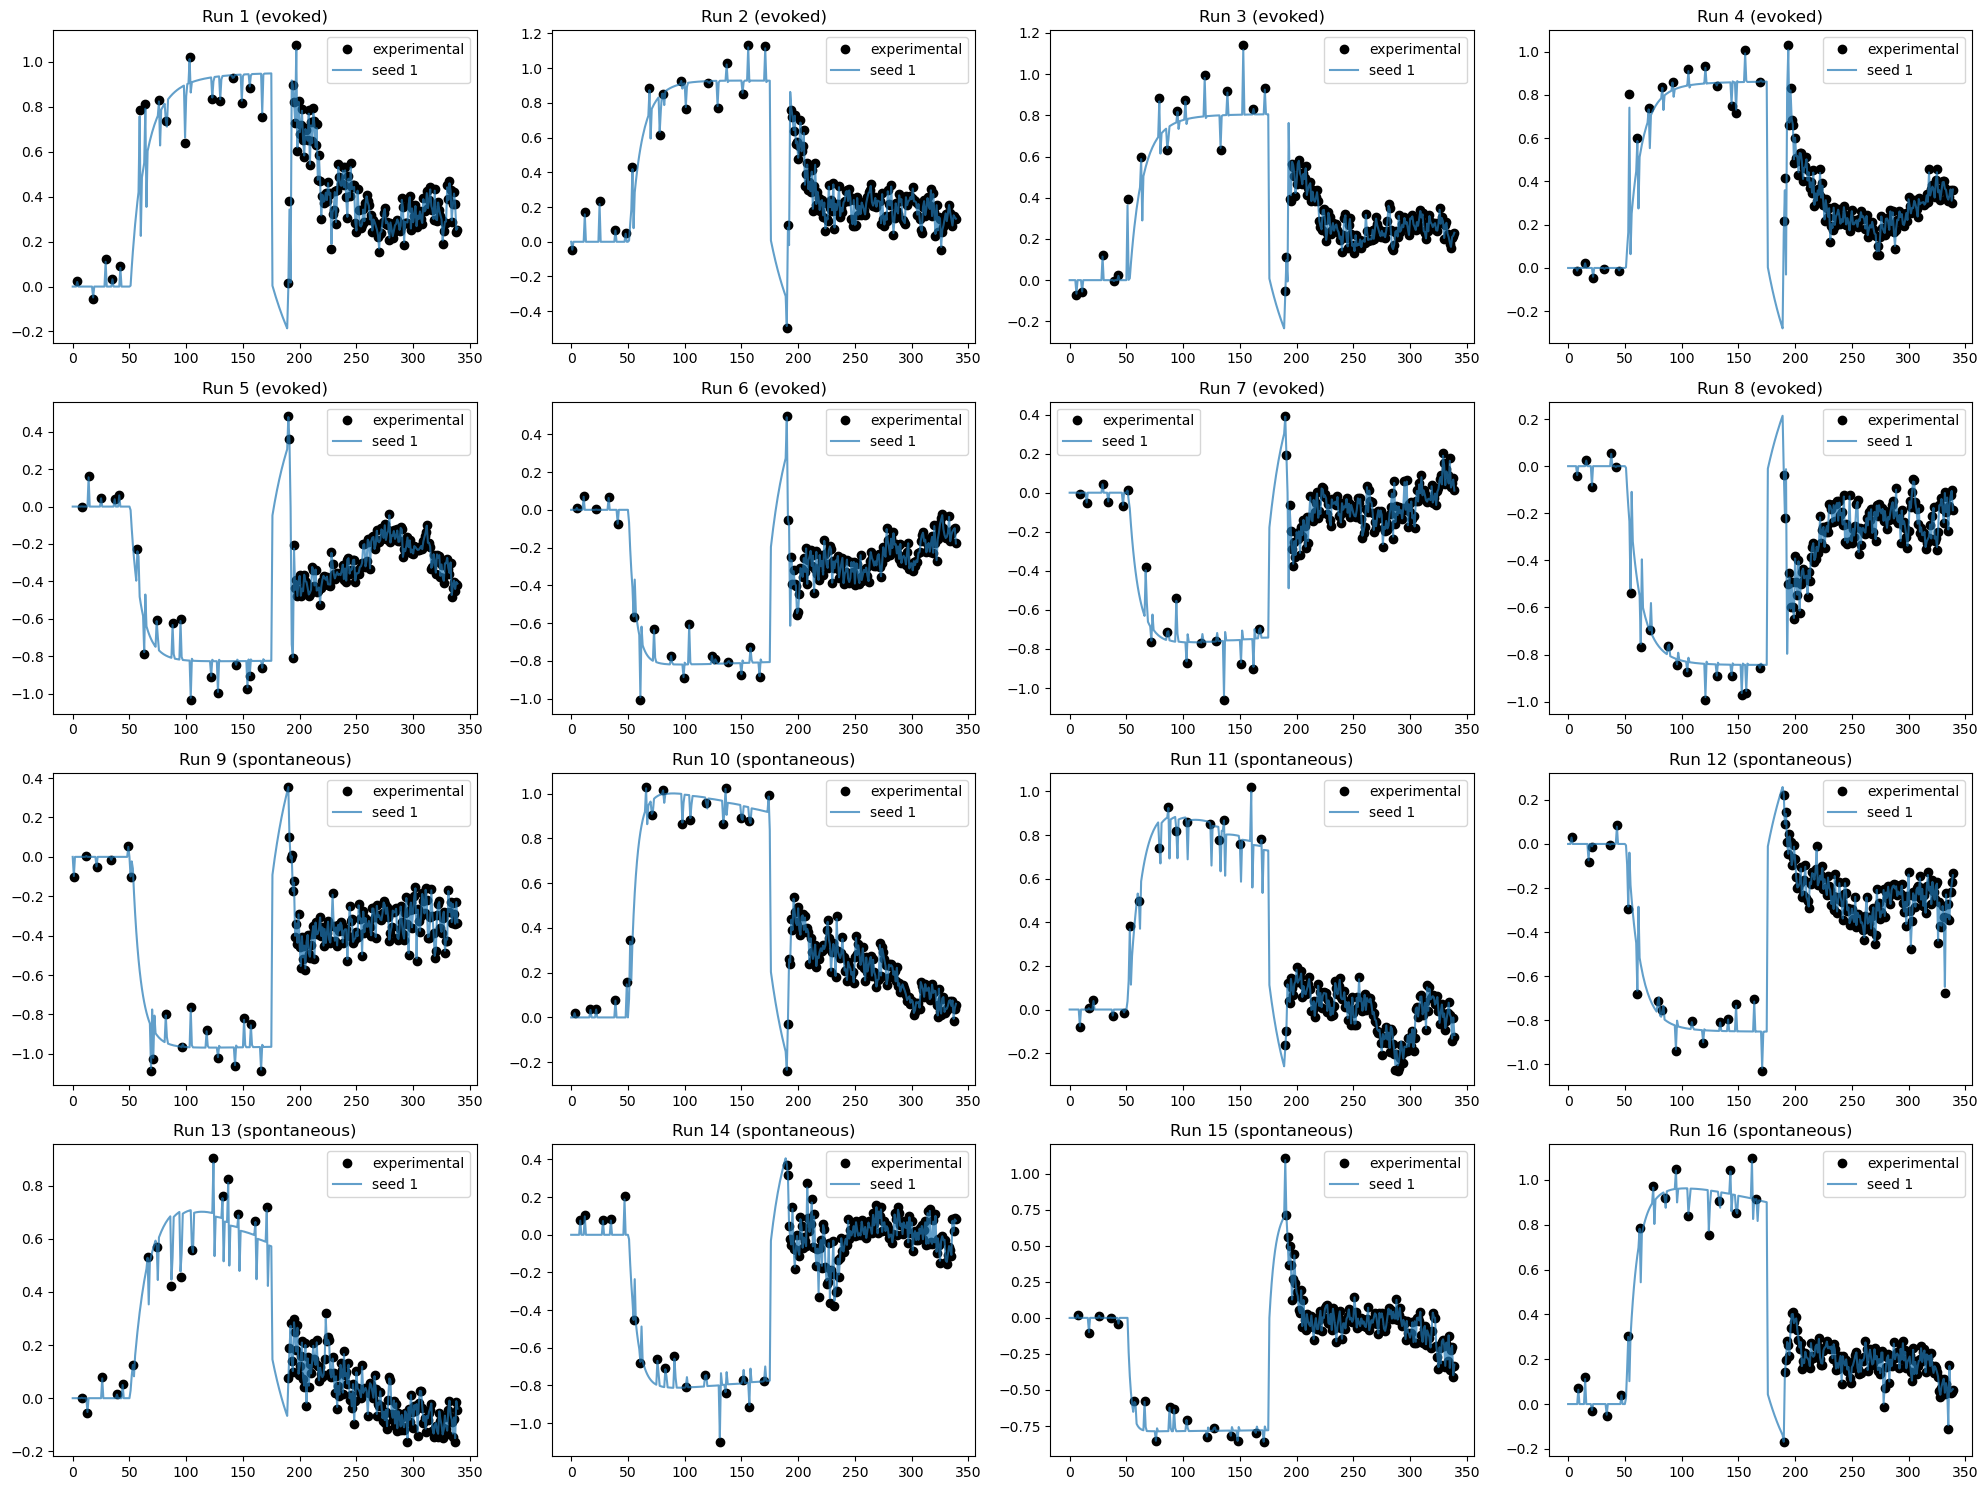

In [176]:
#plot output traces vs experimental data. subplot per run and line per seed
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    ax.plot(exp_datasets[i-1], 'o', label='experimental', color='black', linewidth=2)
    for j in range(1,6):
        if output_traces[(i,j)] is not None:
            ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

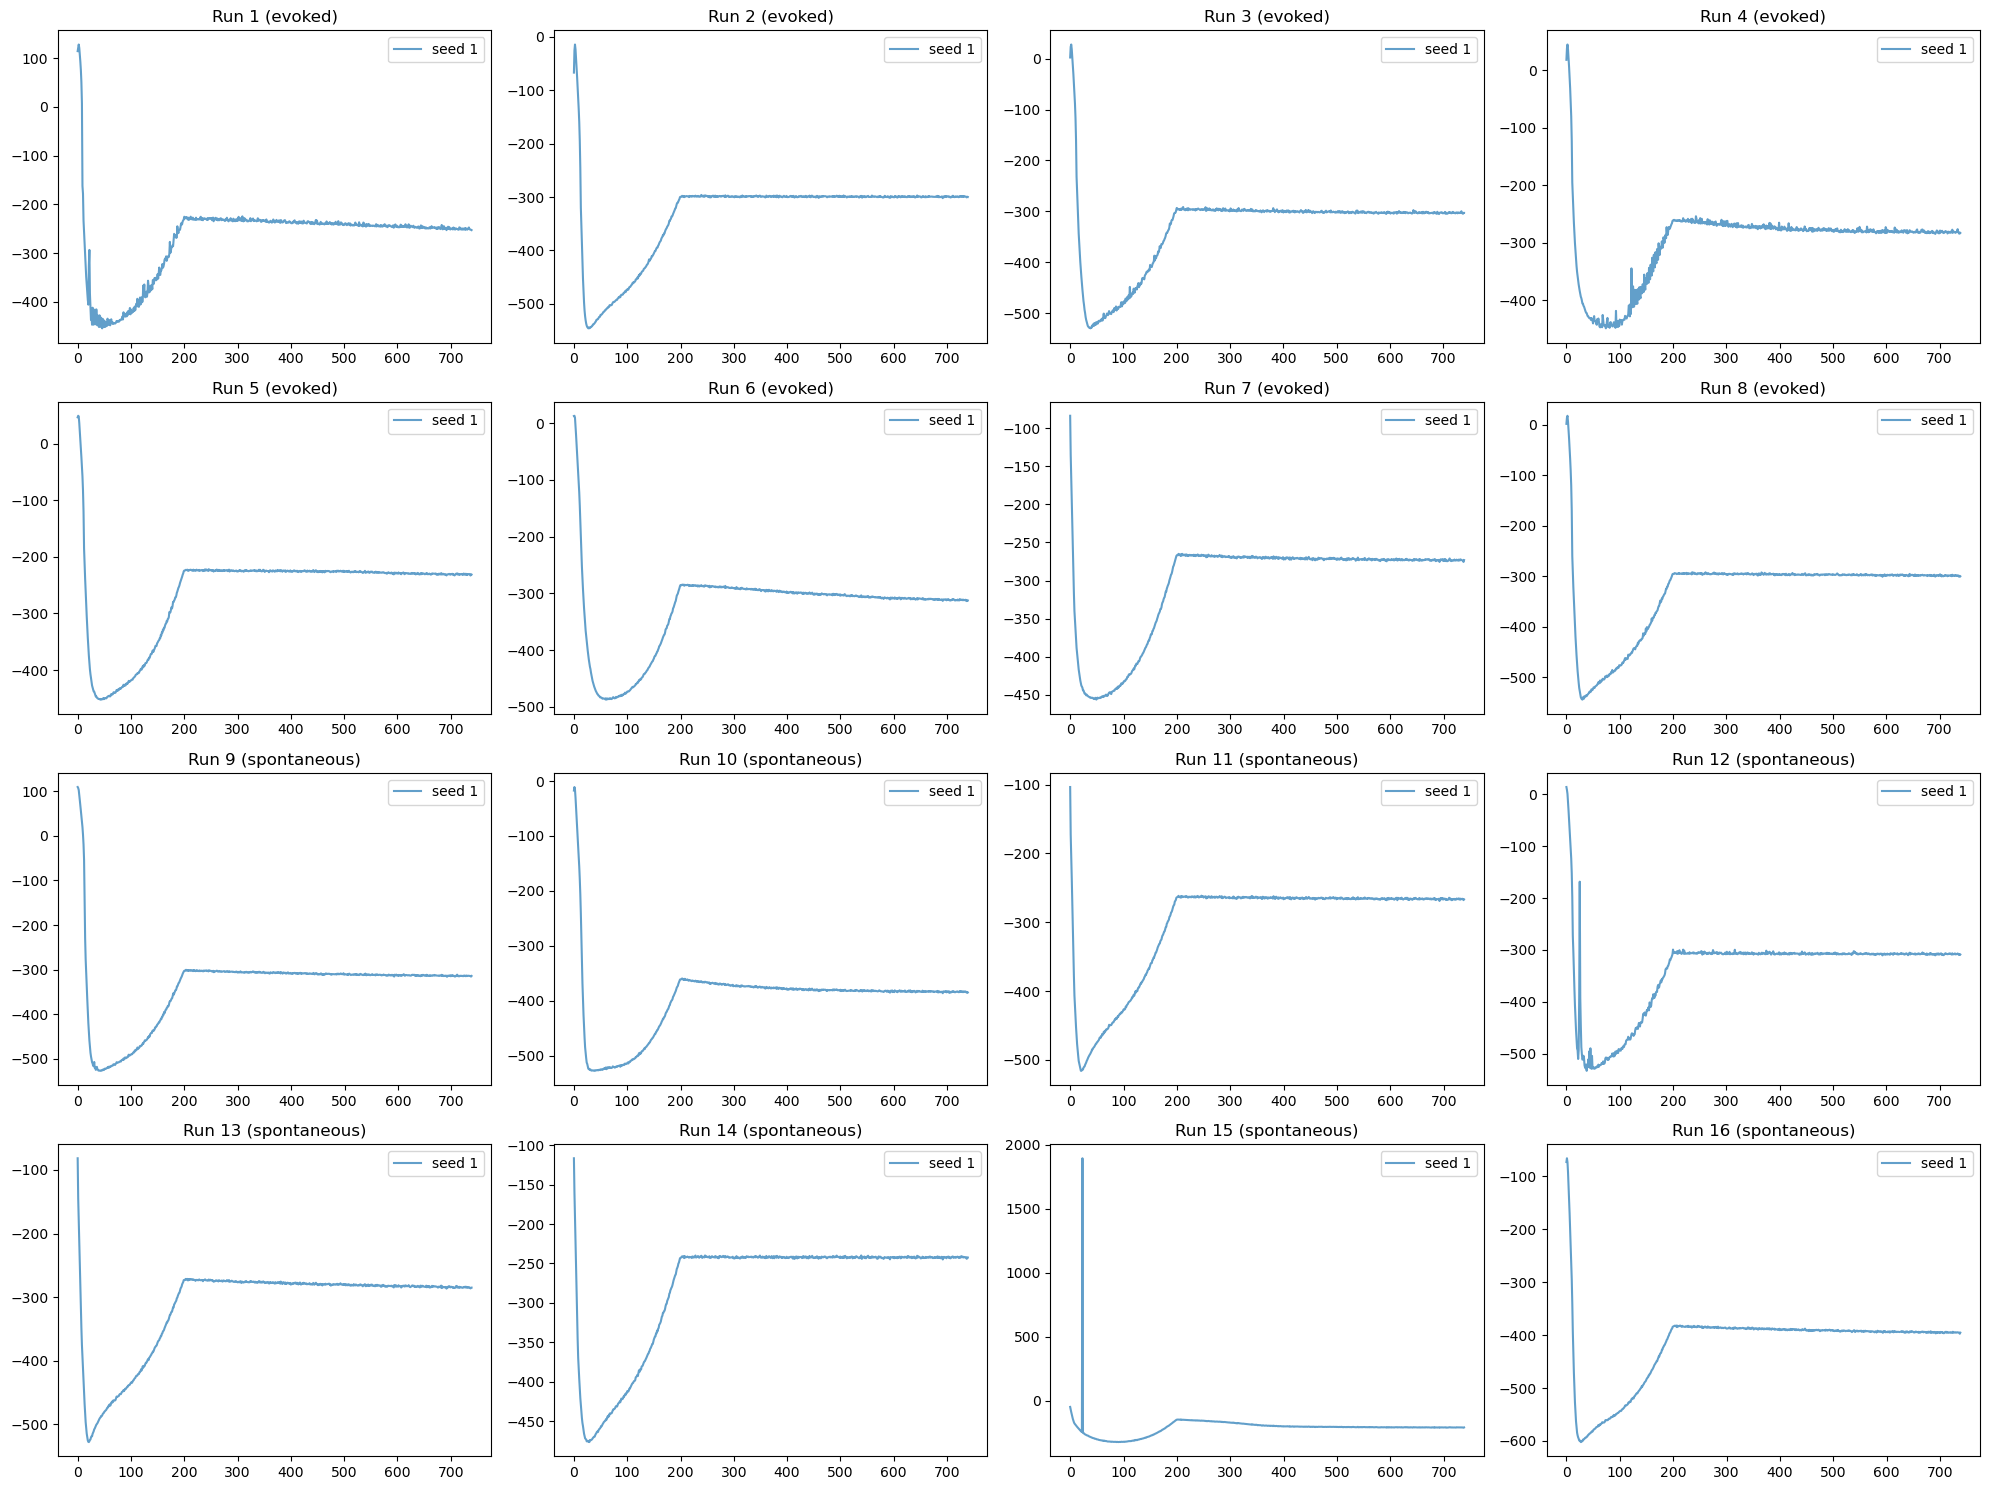

In [177]:
k = 6
VALID_AFTER = 2000
best_bics = []
fig, axs = plt.subplots(4, 4, figsize=(20, 15))
for i in range(1,17):
    ax = axs[(i-1)//4, (i-1)%4]
    n = np.sum(~np.isnan(exp_datasets[i-1]))
    # sum(~np.isnan(exp_data))
    these_bics = []
    for j in range(1,6):
        if output_traces[(i,j)] is not None:
            nll = loss_traces[(i,j)][:,1] * (n if LOSS_IS_PER_SAMPLE else 1)
            bic = 2*nll + k * np.log(n)
            if np.max(loss_traces[(i,j)][:,0]) > VALID_AFTER:
                these_bics.append(bic[-1])
            ax.plot(bic, label=f'seed {j}', alpha=0.7)
    best_bics.append(min(these_bics) if len(these_bics)>0 else None)
    ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

# for ii in range(1,17):
#     plt.subplot(4,4,1 if ii<8 else 2)
#     n = sum(~np.isnan(exp_data))
#     nll = loss_traces[ii][:,1] * (n if LOSS_IS_PER_SAMPLE else 1)
#     iters = loss_traces[ii][:,0]
#     bic = 2*nll + k * np.log(n)
#     plt.plot(iters,bic, label=f'{result_dirs[ii]} (final: {bic[-1]:.1f})')
#     clnn_bics.append(bic[-1])
#     plt.ylim([-500,-200])

In [178]:
# #plot every result in a separate subplot overlayed with     exp_data
# plt.figure(figsize=(12, 12))
# for ii, result_dir in enumerate(result_dirs):
#     # plt.subplot(2, len(result_dirs)//2, ii+1)
#     plt.subplot(4, 4, ii+1)
#     plt.plot(output_traces[ii], '.-' , label='model_output', linewidth=0.3)
#     plt.plot(exp_datasets[ii],'o', label='exp_data', linewidth=1, alpha=0.5)
#     plt.title(result_dir)
#     plt.ylim([-0.7,1.3])
#     plt.legend()
#     rmse = np.sqrt(np.nanmean((output_traces[ii] - exp_datasets[ii])**2))
#     plt.text(0.5, 0.1, f'RMSE: {rmse:.3f},\n neg-elbo: {loss_traces[ii][-1,1]:.3f}\n neg-elbo-min: {loss_traces[ii][201:,1].min():.3f}', transform=plt.gca().transAxes, ha='center')
# plt.show()

In [179]:
best_bics

[-252.8192977511847,
 -299.8425658821139,
 -303.15912342245934,
 -283.1317672560136,
 -231.16867009010394,
 -312.4401824624186,
 -273.14623356458725,
 -300.28505563008076,
 -314.3121013149027,
 -384.78948513891754,
 -266.7949992073199,
 -308.6660791473923,
 -285.07645881763887,
 -242.39212074992332,
 -206.84610816281082,
 -395.37827164336267]

Text(0, 0.5, 'BIC difference (CLNN - COIN) [nats], negative = we are better')

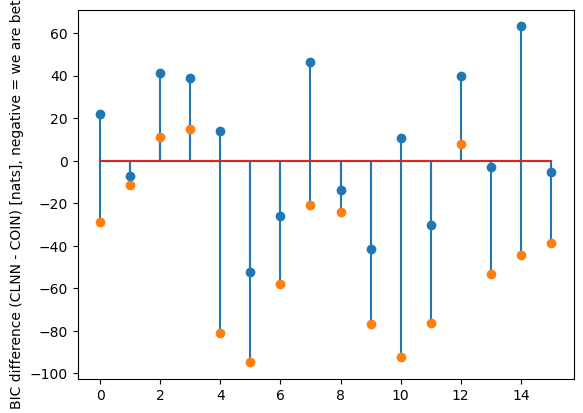

In [180]:
latestngreatest_delta_bics = np.loadtxt('delta_bics.txt')
plt.stem(np.array(np.array(best_bics)-coin_bics), 'o')
plt.stem(latestngreatest_delta_bics, 'x')
plt.ylabel('BIC difference (CLNN - COIN) [nats], negative = we are better')

Text(0, 0.5, 'BIC difference (CLNN - COIN) [nats], negative = we are better')

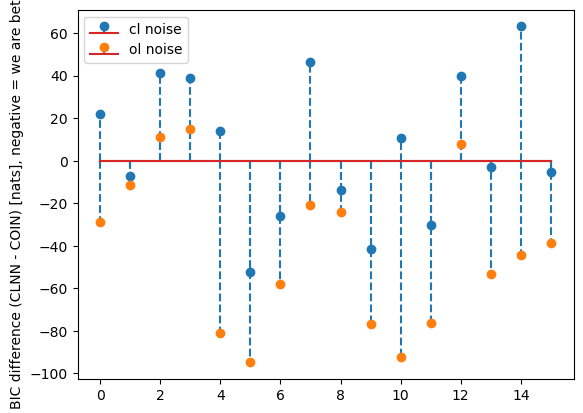

In [ ]:
latestngreatest_delta_bics = np.loadtxt('delta_bics.txt')
plt.stem(np.array(np.array(best_bics)-coin_bics), 'o', linefmt='--')
plt.stem(latestngreatest_delta_bics, 'x', linefmt='--')
plt.legend(['OL noise', 'CL noise'])
plt.ylabel('BIC difference (CLNN - COIN) [nats], negative = we are better')

In [182]:
plt.plot(loss_traces[14][:,0], loss_traces[14][:,1])

KeyError: 14

In [ ]:
plt.plot(coin_bics[:8], clnn_bics, 'o')
plt.plot([min(clnn_bics), max(clnn_bics)], [min(clnn_bics), max(clnn_bics)], 'k--')

NameError: name 'clnn_bics' is not defined

Text(0.5, 1.0, 'BIC over iterations')

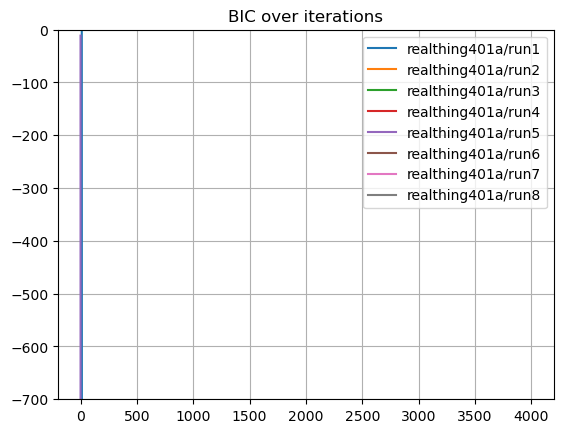

In [ ]:
k = 6
n = sum(~np.isnan(exp_data))
for ii in range(len(result_dirs)):
    nll = loss_traces[ii][:,1] * n
    bic = 2*nll + k * np.log(n)
    plt.plot(bic, label=result_dirs[ii])
plt.legend()
plt.grid()
plt.ylim([-700,0])
plt.title('BIC over iterations')

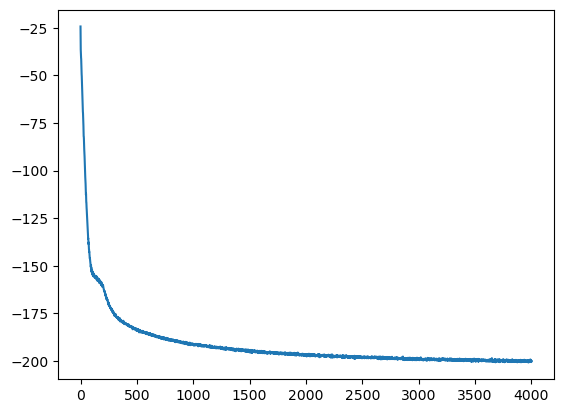

In [ ]:
plt.plot(loss_traces[ii][:,1])

In [ ]:
pwd

'/homes/ar2342'

In [ ]:
# toydir = 'recover100ptsMonte512detachPro0p05Obs0p1'
# toydir = 'recover100ptsMonte512detachPro0p05Obs0p1'
toydir = 'recoverTemp'
toypost = np.loadtxt(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/{toydir}/post_sigma.txt')
toypost12 = np.loadtxt(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/{toydir}/post_sigma12.txt')
toypost_mu = np.loadtxt(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/{toydir}/post_mu.txt')
toy_preda = np.loadtxt(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/{toydir}/pred_a.txt')
toy_synth_a = np.loadtxt(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/{toydir}/toysynth_a.txt')

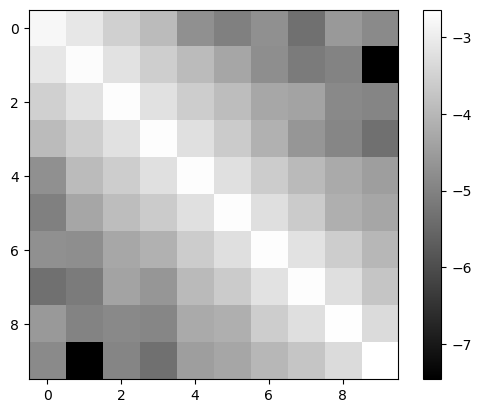

In [ ]:
plt.imshow(np.log10(np.abs(toypost)), cmap='gray')
plt.colorbar()

/tmp/ipykernel_826573/3482281984.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(toypost12)), cmap='gray')


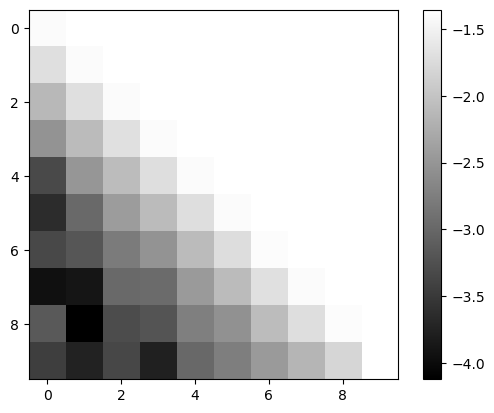

In [ ]:
plt.imshow(np.log10(np.abs(toypost12)), cmap='gray')
plt.colorbar()

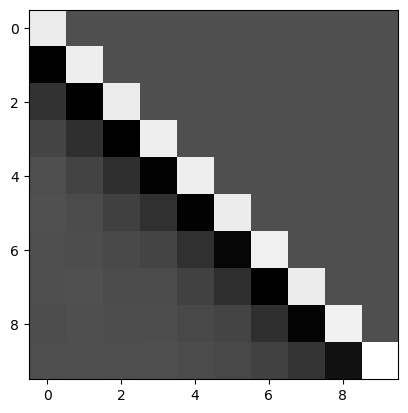

In [ ]:
plt.imshow(toypost12, cmap='gray')

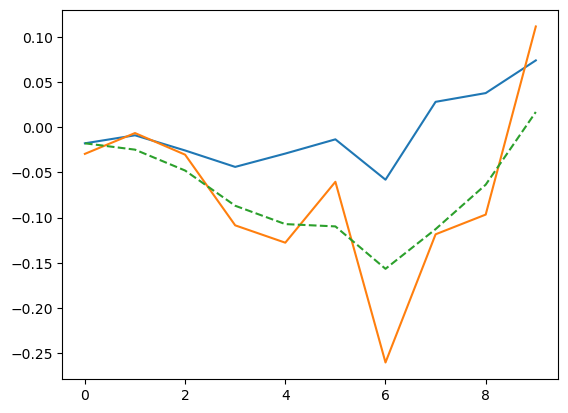

In [ ]:
plt.plot(toypost_mu)
plt.plot(toy_synth_a)
plt.plot(toy_preda,'--')

In [ ]:
np.mean(toy_synth_a)

-0.0726656075567007

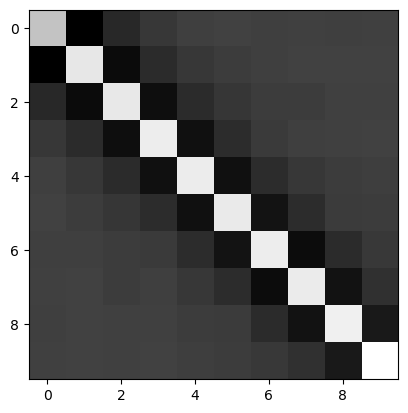

In [ ]:
plt.imshow(toypost12 @ toypost12.T, cmap='gray')

In [ ]:
trajs1 = np.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/temp101m67p8s104/pred_a_batch.npz')
trajs2 = np.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/temp101m160p5s103/pred_a_batch.npz')

In [ ]:
trajs.files[0]

'as'

In [ ]:
trajs

In [ ]:
trajs.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x70f774167ac0>)

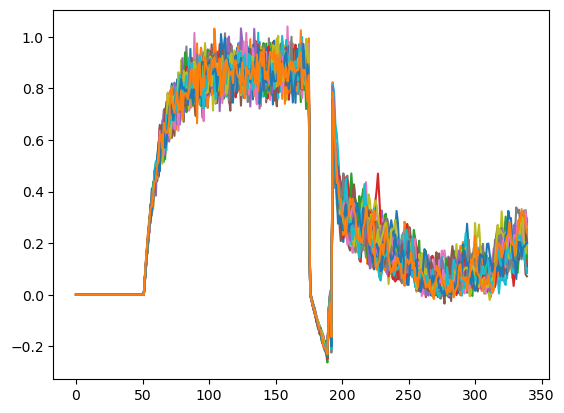

In [ ]:
plt.plot(trajs['as'])

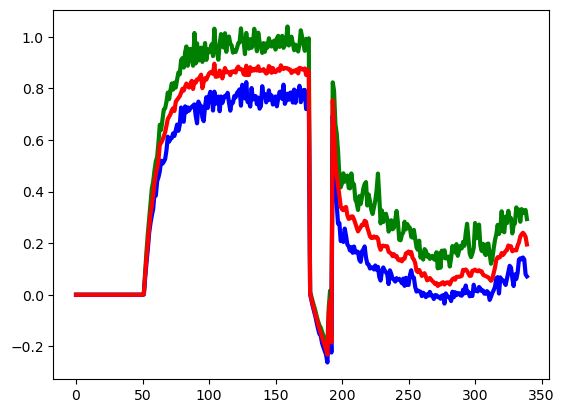

In [ ]:
plt.plot(trajs['as'].max(axis=1), 'g', linewidth=3)
plt.plot(trajs['as'].min(axis=1), 'b', linewidth=3)
plt.plot(trajs['as'].mean(axis=1), 'r', linewidth=3)

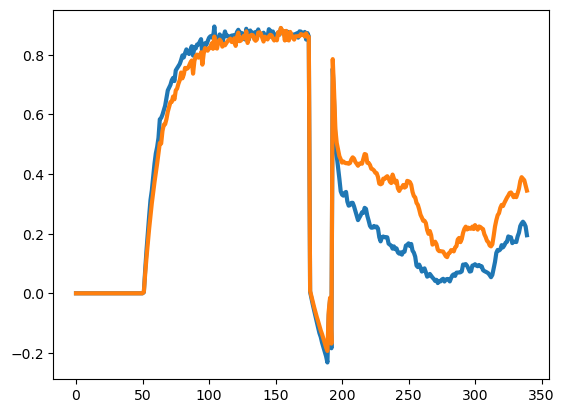

In [ ]:
for these_trajs in [trajs1, trajs2]:
    # plt.plot(these_trajs['as'].max(axis=1), 'g', linewidth=3)
    # plt.plot(these_trajs['as'].min(axis=1), 'b', linewidth=3)
    plt.plot(these_trajs['as'].mean(axis=1), linewidth=3)

/tmp/ipykernel_826573/3345047556.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


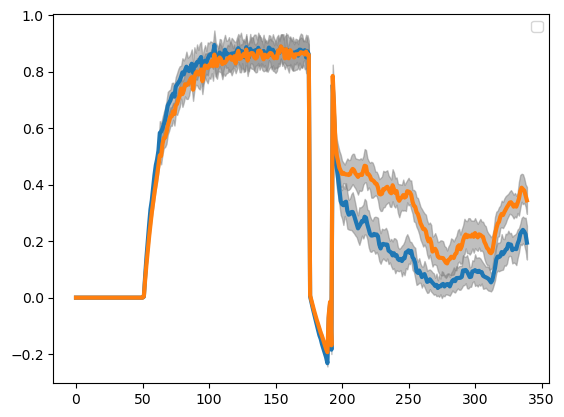

In [ ]:
for these_trajs in [trajs1, trajs2]:
#now plot as mean and shaded region between +/- stddev
    plt.plot(these_trajs['as'].mean(axis=1), linewidth=3)
    stdtraj = these_trajs['as'].std(axis=1)
    plt.fill_between(np.arange(len(stdtraj)), these_trajs['as'].mean(axis=1)-stdtraj, these_trajs['as'].mean(axis=1)+stdtraj, color='gray', alpha=0.5)
    plt.legend()


In [ ]:
#ranksum of timepoint 225 on the two trajs
import scipy.stats as stats
o = stats.ranksums(trajs1['as'][225, :], trajs2['as'][225, :])
print(o)

RanksumsResult(statistic=-6.7001497902314435, pvalue=2.082060062705088e-11)


/tmp/ipykernel_826573/3789321778.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(180.0, 200.0)

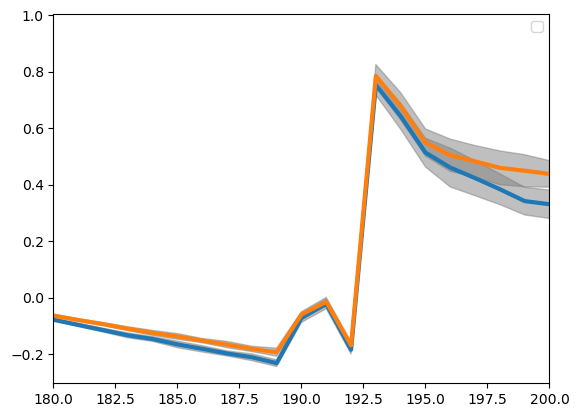

In [ ]:
for these_trajs in [trajs1, trajs2]:
#now plot as mean and shaded region between +/- stddev
    plt.plot(these_trajs['as'].mean(axis=1), linewidth=3)
    stdtraj = these_trajs['as'].std(axis=1)
    plt.fill_between(np.arange(len(stdtraj)), these_trajs['as'].mean(axis=1)-stdtraj, these_trajs['as'].mean(axis=1)+stdtraj, color='gray', alpha=0.5)
    plt.legend()
plt.xlim([180,200])


In [ ]:
sr_df = pd.read_csv('/homes/ar2342/frogs_project/data/COIN_data/trial_data_spontaneous_recovery_participant1.csv')
mu_df = pd.read_csv('/homes/ar2342/frogs_project/data/COIN_data/trial_data_memory_updating_participant1.csv')

In [ ]:
sr_df.columns

Index(['BlockName', 'BlockTrial', 'FieldConstants_1', 'FieldConstants_2',
       'FieldType', 'MissTrial', 'RestFlag', 'TrialNumber', 'TargetPosition_1',
       'TargetPosition_2', 'MovementReactionTime', 'MovementDurationTime',
       'Adaptation'],
      dtype='object')

In [ ]:
mu_df.columns

Index(['BlockName', 'BlockTrial', 'ControlPoint', 'FieldConstants_1',
       'FieldConstants_2', 'FieldType', 'MissTrial', 'RestFlag', 'TrialNumber',
       'TargetPosition_1', 'TargetPosition_2', 'MovementReactionTime',
       'MovementDurationTime', 'Adaptation'],
      dtype='object')

In [ ]:
# check for any names that are in sr_df but not in mu_df and vice versa
print(set(sr_df.columns) - set(mu_df.columns))
print(set(mu_df.columns) - set(sr_df.columns))

set()
{'ControlPoint'}


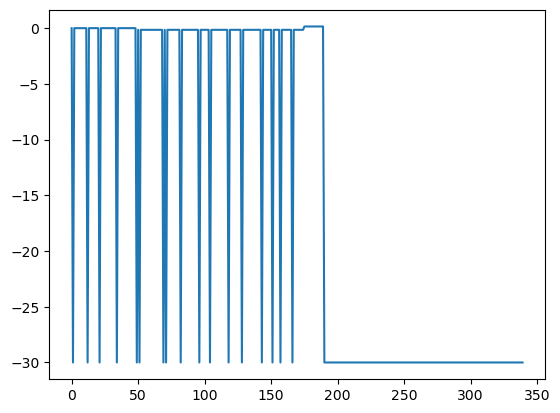

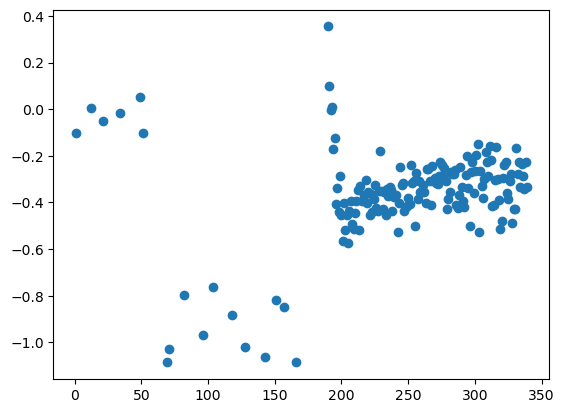

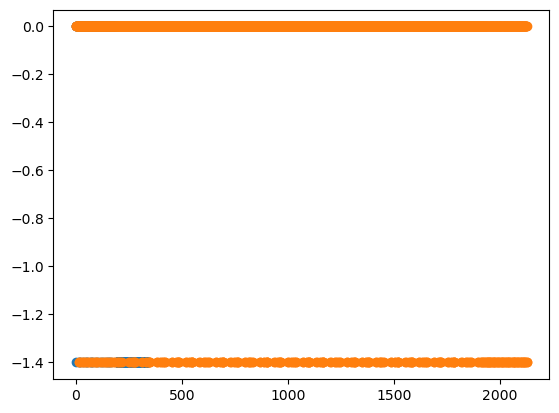

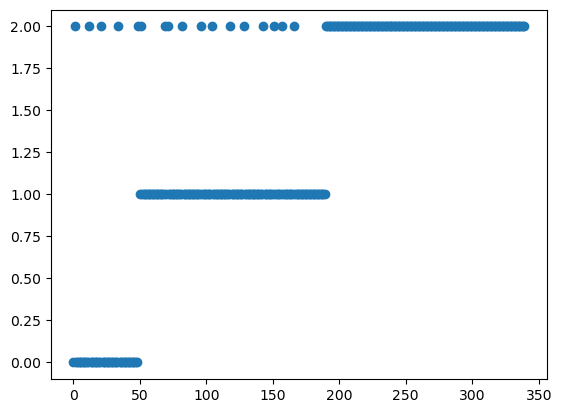

In [ ]:
plt.plot(sr_df.FieldConstants_1)
plt.figure()
plt.plot(sr_df.Adaptation, 'o')
plt.figure()
plt.plot(sr_df.FieldConstants_2, 'o')
plt.plot(mu_df.FieldConstants_2, 'o')

plt.figure()
plt.plot(sr_df.FieldType, 'o')
# plt.plot(mu_df.FieldType, 'x')

In [ ]:
def load_subject_data(filename, ff_mult = 1./0.15):
    df = pd.read_csv(filename)
    a = df.Adaptation.to_numpy()
    y = ff_mult * df.FieldConstants_1.to_numpy()
    channel_trials  = np.logical_not(np.isnan(a))
    y[channel_trials] = np.nan
    q = df.ControlPoint.to_numpy() if 'ControlPoint' in df.columns else np.zeros_like(a)

    return a, y, q

In [ ]:
# a,y,q = load_subject_data('/homes/ar2342/frogs_project/data/COIN_data/trial_data_spontaneous_recovery_participant1.csv')
a,y,q = load_subject_data('/homes/ar2342/frogs_project/data/COIN_data/trial_data_memory_updating_participant1.csv')

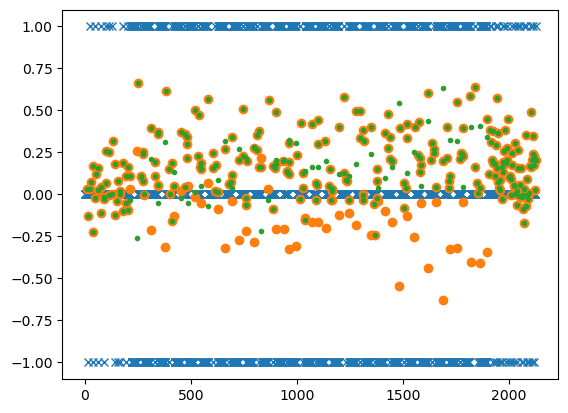

In [ ]:
plt.plot(y,'x')
plt.plot(a,'o')
plt.plot(a*q,'.')

In [ ]:
q

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
temp_pred_a  = np.loadtxt(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/temp11/pred_a.txt')
temp_params  = torch.load(f'/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/temp11/params.pt')



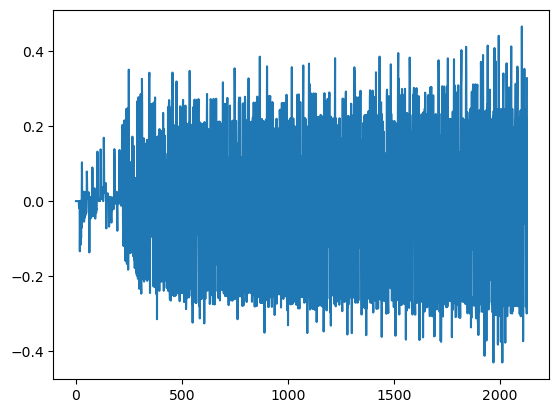

In [ ]:
plt.plot(temp_pred_a, label='model')

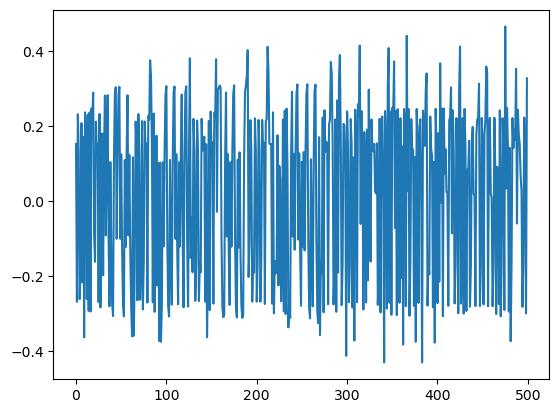

In [ ]:
plt.plot(temp_pred_a[-500:], label='model')

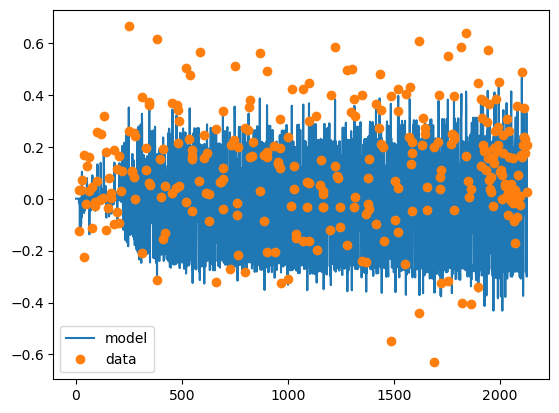

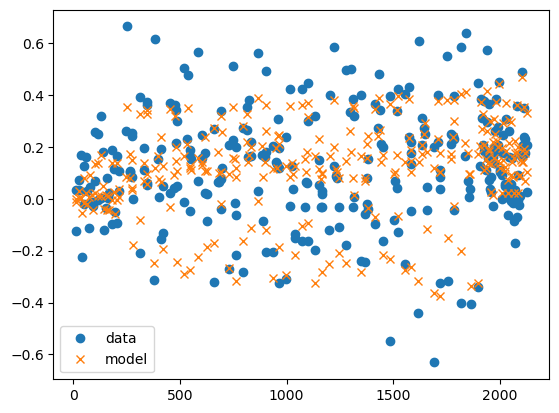

In [ ]:
x_a = np.arange(len(temp_pred_a))
plt.plot(x_a, temp_pred_a, label='model')
plt.plot(x_a, a, 'o', label='data')
plt.legend()
plt.figure()
valas = np.logical_not(np.isnan(a))
plt.plot(x_a[valas], a[valas], 'o', label='data')
plt.plot(x_a[valas], temp_pred_a[valas],'x', label='model')
plt.legend()


(100.0, 400.0)

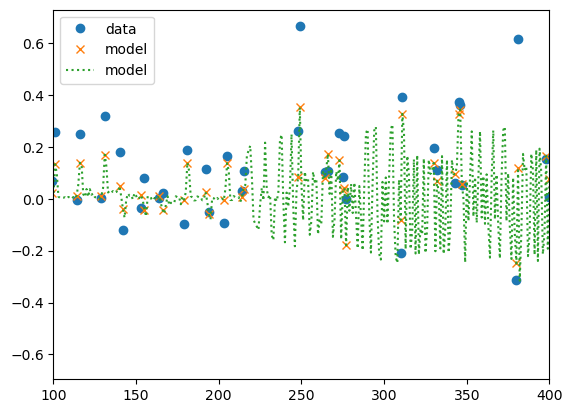

In [ ]:
valas = np.logical_not(np.isnan(a))
plt.plot(x_a[valas], a[valas], 'o', label='data')
plt.plot(x_a[valas], temp_pred_a[valas],'x', label='model')
plt.plot(x_a, temp_pred_a,':', label='model')
plt.legend()
plt.xlim([100,400])

(2000.0, 2128.0)

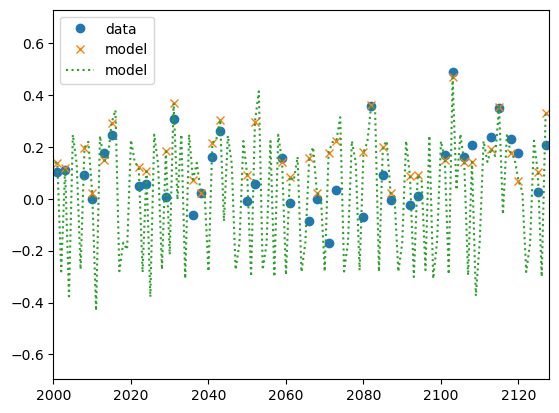

In [ ]:
valas = np.logical_not(np.isnan(a))
plt.plot(x_a[valas], a[valas], 'o', label='data')
plt.plot(x_a[valas], temp_pred_a[valas],'x', label='model')
plt.plot(x_a, temp_pred_a,':', label='model')
plt.legend()
plt.xlim([2000,2128])

In [ ]:
temp_params

OrderedDict([('gen.log_learning_rate', tensor([-6.1842], device='cuda:0')),
             ('gen.log_learning_rate_decay',
              tensor([0.2759], device='cuda:0')),
             ('gen.sigma_b', tensor([-0.2465], device='cuda:0')),
             ('gen.output_scale', tensor([0.8453], device='cuda:0')),
             ('gen.log_weight_decay', tensor([0.0001], device='cuda:0')),
             ('gen.q_scale', tensor([0.6957], device='cuda:0')),
             ('gen.sigma_x', tensor([0.5684], device='cuda:0')),
             ('gen.tauqlpf_m1', tensor([-1.3040], device='cuda:0')),
             ('gen._z_biases',
              tensor([-0.6974, -1.8688, -0.8832, -1.6627, -0.4324,  0.9505,  0.6620,  0.0446,
                       0.5720,  2.1951, -0.2474, -1.3831,  0.0602, -0.2431,  1.3181,  0.5211,
                      -0.6087,  0.1000, -0.8960, -0.9373, -0.2666,  1.5304,  0.5584, -0.9451,
                       0.1321,  1.2452,  0.1467, -0.4605,  0.6020,  1.3719, -1.9693,  0.9137,
             

In [ ]:
# a,y,q = load_subject_data('/homes/ar2342/frogs_project/data/COIN_data/trial_data_spontaneous_recovery_participant1.csv')
a,y,q = load_subject_data('/homes/ar2342/frogs_project/data/COIN_data/trial_data_memory_updating_participant1.csv')

In [ ]:
y

array([ 0.,  0.,  0., ..., nan,  1., nan])

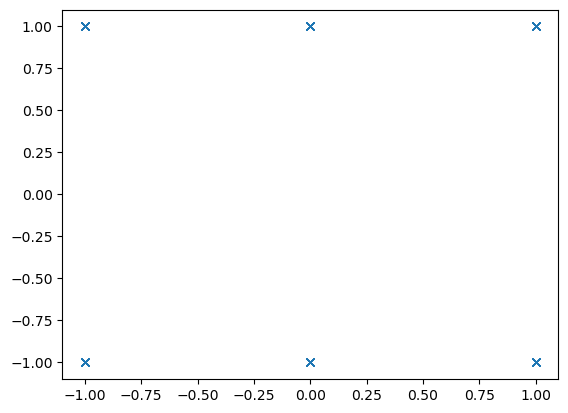

In [ ]:
plt.plot(y[-500:], q[-500:], 'x')

(500.0, 600.0)

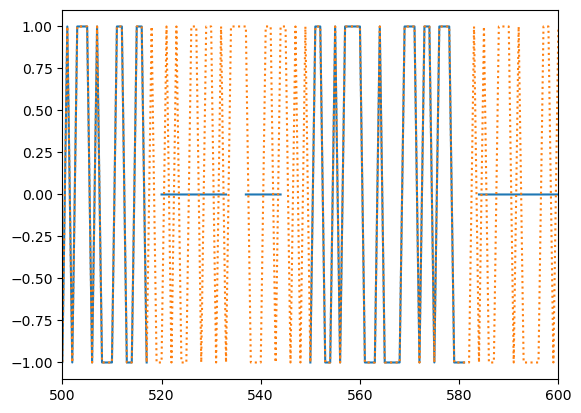

In [ ]:
plt.plot(y)
plt.plot(q,':')
plt.xlim([500,600])

(2000.0, 2100.0)

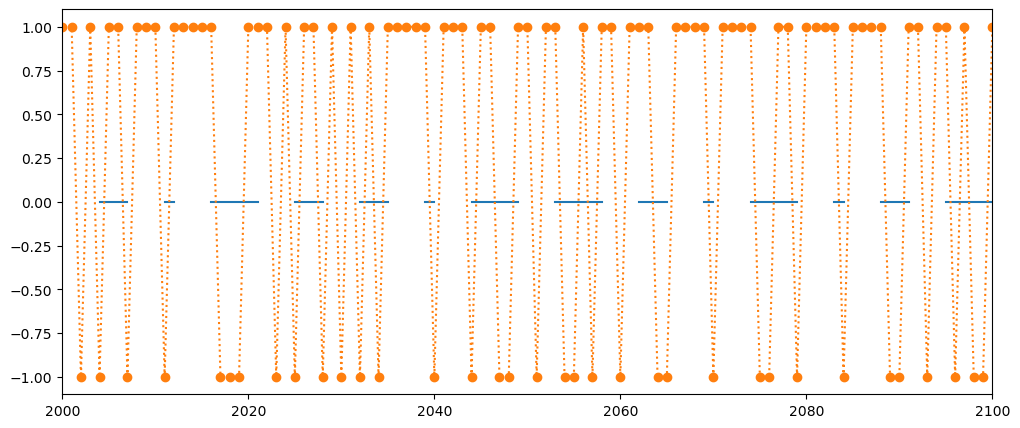

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y)
plt.plot(q,':o')
plt.xlim([2000,2100])

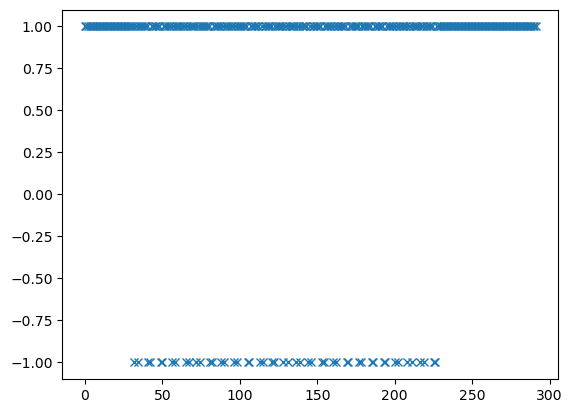

In [ ]:
plt.plot(q[np.isnan(y)], 'x')